# Near-Surface Air Temperature

In [1]:
# To reload external files automatically (ex: utils)
%load_ext autoreload
%autoreload 2

import xarray as xr
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import proplot as plot # New plot library (https://proplot.readthedocs.io/en/latest/)
from scipy import stats
import xesmf as xe # For regridding (https://xesmf.readthedocs.io/en/latest/)

import sys
sys.path.insert(1, '/home/mlalande/notebooks/utils') # to include my util file in previous directory
import utils as u # my personal functions
u.check_python_version()
# u.check_virtual_memory()

3.8.2 | packaged by conda-forge | (default, Feb 28 2020, 17:15:22) 
[GCC 7.3.0]


## Set variables

In [7]:
period = slice('1979','2014')
latlim, lonlim = u.get_domain_HMA()

var = 'tas'
table = u.get_table(var)
label, units, cmap, levels = u.get_var_infos(var)
label

'Near-Surface Air Temperature'

## Load topography

In [8]:
ds = xr.open_dataset('GMTED2010_15n240_1000deg.nc').drop_dims('nbounds').swap_dims(
    {'nlat': 'latitude', 'nlon': 'longitude'}).drop({'nlat', 'nlon'}).rename(
    {'latitude': 'lat', 'longitude': 'lon'}).sel(lat=latlim, lon=lonlim)
elevation = ds.elevation
elevation_std = ds.elevation_stddev

## Load obs
cru_ts4.00: https://crudata.uea.ac.uk/cru/data/hrg/

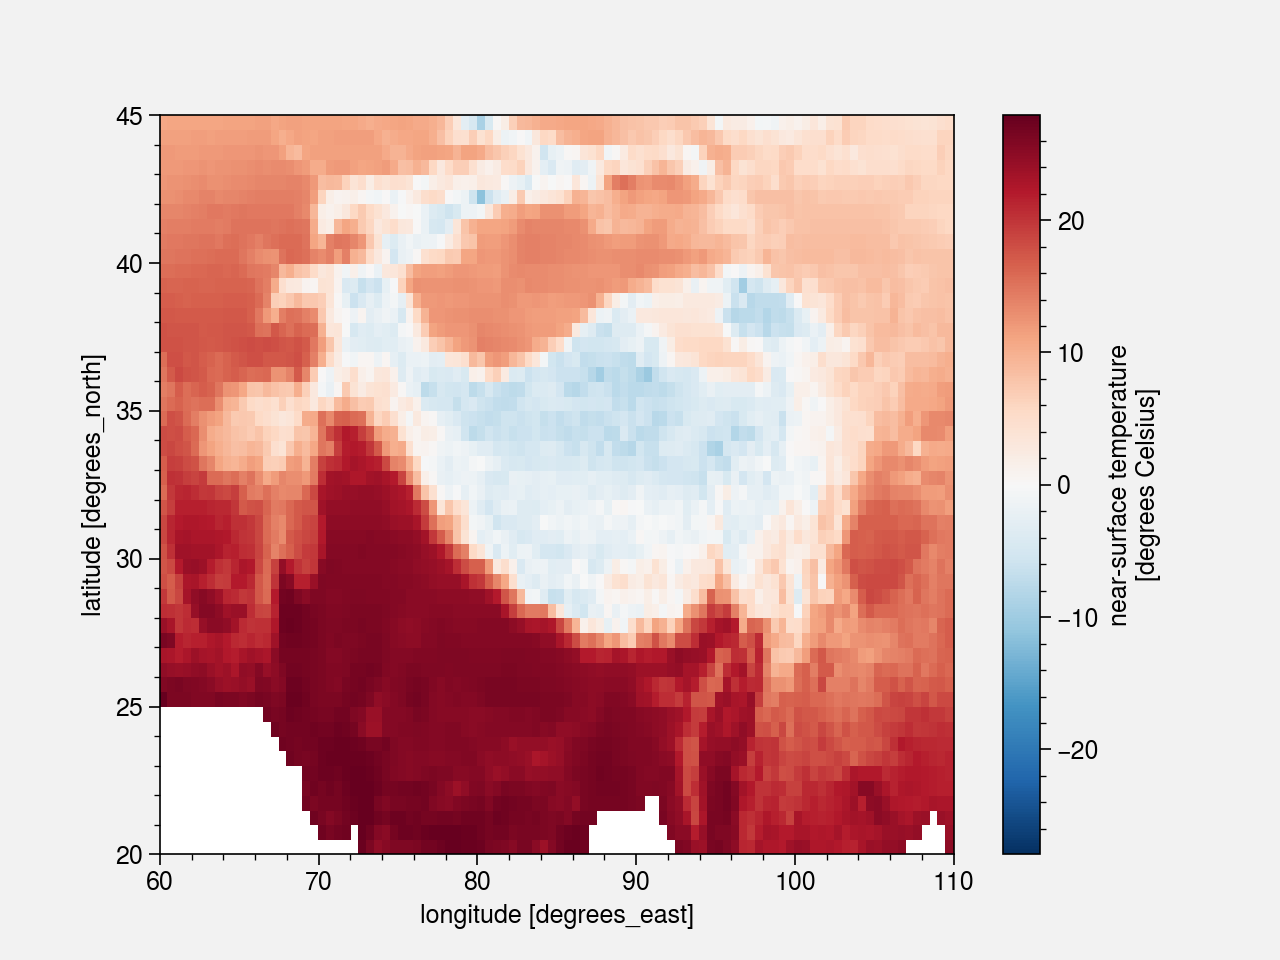

In [9]:
obs_longname = 'CRU TS v. 4.00'
obs_name = 'CRU'

obs = xr.open_dataset('/bdd/cru/cru_ts_4.00/data/tmp/cru_ts4.00.1901.2015.tmp.dat.nc').sel(
    time=period, lat=latlim, lon=lonlim).tmp
obs_clim = u.clim(obs, calendar=obs.time.encoding['calendar'])
obs_clim.plot()

## Regrid obs towards the elevation grid of 1°x1°
Using xESMF (https://xesmf.readthedocs.io/en/latest/)

In [10]:
regridder = xe.Regridder(obs_clim, elevation, 'bilinear', periodic=False, reuse_weights=True)
obs_clim_regrid = regridder(obs_clim)

Reuse existing file: bilinear_50x100_25x50.nc


## Load models

In [22]:
list_models = u.get_model_names()

bias = []

for model in list_models[:2]:
    print(model)
    institute, grid, realization = u.get_model_infos(model, var)
    model_clim = xr.open_mfdataset(
        '/bdd/CMIP6/CMIP/'+institute+'/'+model+'/historical/'+realization+'/'+table+'/'+var+'/'+grid+'/latest/*.nc', combine='by_coords'
    ).sel(time=period, 
          lat=slice(latlim.start-5, latlim.stop+5), # Add 5° for the regrid
          lon=slice(lonlim.start-5, lonlim.stop+5))[var].mean('time') - 273.15
    
    # Regrid towards elevation grid 1°x1°
    regridder = xe.Regridder(model_clim, elevation, 'bilinear', periodic=False, reuse_weights=True)
    model_clim_regrid = regridder(model_clim)
    
    bias.append(model_clim_regrid - obs_clim_regrid)

BCC-CSM2-MR
Create weight file: bilinear_32x54_25x50.nc
BCC-ESM1
Create weight file: bilinear_13x21_25x50.nc


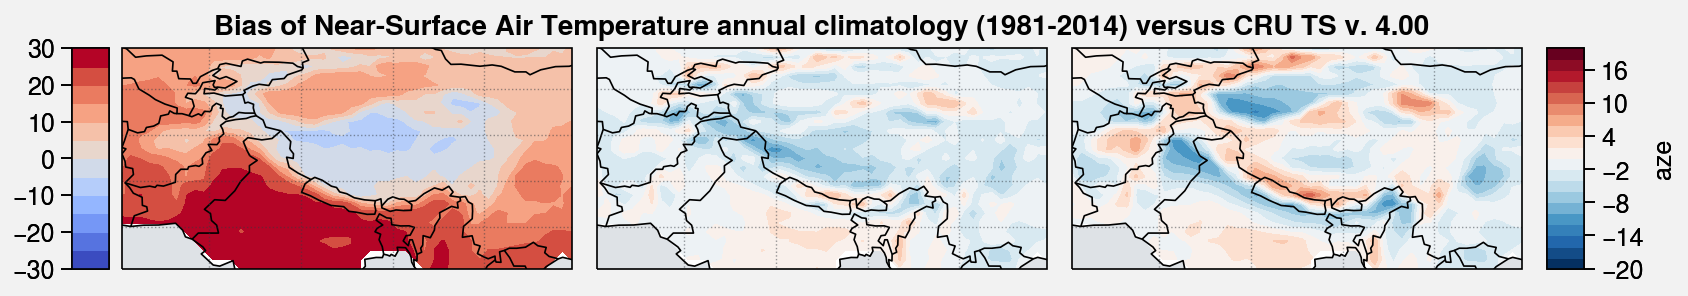

In [23]:
f, axs = plot.subplots(proj='cyl', ncols=3, nrows=1)

for i, ax in enumerate(axs):
    if i == 0:
        axs[i].contourf(obs_clim_regrid, cmap=cmap, levels=levels, colorbar='l')
    else:
        #Plot
        m = axs[i].contourf(bias[i-1], cmap='RdBu_r', levels=plot.arange(-20,20,2))

        # Compute RMSE
    #     rmse = np.sqrt((bias[i].sel(lat=slice(latlim[0],latlim[1]), lon=slice(lonlim[0],lonlim[1]))**2).mean().values)

    #     axs[i].format(
    #         title=list_models[i],
    #         lltitle='RMSE = '+str(round(rmse,1)) +' °C'
    #     )
    
    
f.colorbar(m, label='aze', loc='r')

axs.format(
    geogridlinewidth=0.5, geogridcolor='gray8', geogridalpha=0.5, labels=False, 
    coast=True, ocean=True, oceancolor='gray3', borders=True,
    suptitle="Bias of Near-Surface Air Temperature annual climatology (1981-2014) versus "+obs_longname,
    lonlines=10, latlines=5, abc=False,
    latlim=(elevation.lat.min(), elevation.lat.max()), 
    lonlim=(elevation.lon.min(), elevation.lon.max())
)

# f.save('img/'+var+'_bias_multimodel.jpg')
# f.save('img/'+var+'_bias_multimodel.png')
# f.save('img/'+var+'_bias_multimodel.pdf')